In [ ]:
!pip install datasets transformers tokenizers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

## Let's implement CCS from scratch.
This will deliberately be a simple (but less efficient) implementation to make everything as clear as possible.


In [ ]:
import pandas as pd

In [ ]:
data_test = load_dataset("amazon_polarity")["test"]
data_train = load_dataset("amazon_polarity")["train"]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
test_df = pd.DataFrame(data_test)

In [ ]:
train_df = pd.DataFrame(data_train)

In [ ]:
test_df.describe()

In [ ]:
from tqdm import tqdm
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression

# Let's just try IMDB for simplicity
data = load_dataset("amazon_polarity")["test"]

# Here are a few different model options you can play around with:
model_name = "deberta"
# model_name = "gpt-j"
# model_name = "t5"

# if you want to cache the model weights somewhere, you can specify that here
cache_dir = None

if model_name == "deberta":
    model_type = "encoder"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
    model = AutoModelForMaskedLM.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
    model.cuda()
elif model_name == "gpt-j":
    model_type = "decoder"
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
    model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
    model.cuda()
elif model_name == "t5":
    model_type = "encoder_decoder"
    tokenizer = AutoTokenizer.from_pretrained("t5-11b", cache_dir=cache_dir)
    model = AutoModelForSeq2SeqLM.from_pretrained("t5-11b", cache_dir=cache_dir)
    model.parallelize()  # T5 is big enough that we may need to run it on multiple GPUs
else:
    print("Not implemented!")

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Dataset amazon_polarity downloaded and prepared to /root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


KeyboardInterrupt: ignored

In [ ]:
truthful_qa = load_dataset("truthful_qa", "generation")
truthful_qa

In [ ]:
# understanding the number of samples made available to us
# data_amazon_polarity = load_dataset("amazon_polarity")["train"]
# data_amazon_polarity

In [ ]:
i = 0
ind = 0
select = []
while ind < 1000:
    if len(tokenizer(data[ind]["content"])) < 200:
        select.append(i)
        ind += 1
    i += 1

In [ ]:
data = data.select(select)
data

## First let's write code for extracting hidden states given a model and text. 
How we do this exactly will depend on the type of model.

In [ ]:
def get_encoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, truncation=True, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["hidden_states"]
    
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_encoder_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder-decoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
    decoder_text_ids = tokenizer("", return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, decoder_input_ids=decoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["encoder_hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given a decoder model and some text, gets the hidden states (in a given layer, by default the last) on that input text

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize (adding the EOS token this time)
    input_ids = tokenizer(input_text + tokenizer.eos_token, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(input_ids, output_hidden_states=True)

    # get the last layer, last token hidden states
    hs_tuple = output["hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_hidden_states(model, tokenizer, input_text, layer=-1, model_type="encoder"):
    fn = {"encoder": get_encoder_hidden_states, "encoder_decoder": get_encoder_decoder_hidden_states,
          "decoder": get_decoder_hidden_states}[model_type]

    return fn(model, tokenizer, input_text, layer=layer)

## Now let's write code for formatting data and for getting all the hidden states.


In [ ]:
def format_imdb(text, label, format=3):
    """
    Given an imdb example ("text") and corresponding label (0 for negative, or 1 for positive), 
    returns a zero-shot prompt for that example (which includes that label as the answer).
    
    (This is just one example of a simple, manually created prompt.)

    format: int, a code that tracks the format style we want to use
    """
    labels = ["negative", "positive"]
    if format == 1:
      return f"Consider the following example: “‘ {text} ”’ Between {labels[0]} and {labels[1]}, the sentiment of this example is {labels[label]}\n"
    elif format == 2:
      return f"Q: Is the sentiment of \"{text}\" {labels[0]} or {labels[1]}? A: {labels[label]}\n"
    elif format == 3:
      return "The following movie review expresses a " + ["negative", "positive"][label] + " sentiment:\n" + text
    else:
      raise Exception("Not a valid format code")

    # return f"Consider the following example: “‘ {text} ”’ Between {labels[0]} and {labels[1]}, the sentiment of this example is {labels[label]}\n"
    # return f"Q: Is the sentiment of \"{text}\" {labels[0]} or {labels[1]}? A: {labels[label]}\n"
    # return "The following movie review expresses a " + ["negative", "positive"][label] + " sentiment:\n" + text


def format_amazon_polarity(text, label, format=1):
  labels = ["negative", "positive"]
  return f"Consider the following example: “‘ {text} ”’ Between {labels[0]} and {labels[1]}, the sentiment of this example is {labels[label]}\n"

def format_amazon_polarity_and(text1, text2, label, format=1):
  labels = ["partly negative", "completely positive"]
  return f"Consider the following example: “‘ {text1}. {text2} ”’ Between {labels[0]} and {labels[1]}, the sentiment of this example is {labels[label]}\n"
  # return "The following movie review expresses a " + ["negative", "positive"][label] + " sentiment:\n" + text
  # return f"Each of the following two examples has either positive or negative sentiment. Example 1: “‘ {text1} ”’. Example 2: “‘ {text2} ”’. Q: Do BOTH of these examples have positive sentiment? {labels[label]}\n"
  # Now, consider the statement, “‘Both of these examples have positive sentiment.”’ Between true and false, this statement is {labels[label]}"

def format_amazon_polarity_or(text1, text2, label, format=1):
  labels = ["completely negative", "partly positive"]
  return f"Consider the following example: “‘ {text1}. {text2} ”’ Between {labels[0]} and {labels[1]}, the sentiment of this example is {labels[label]}\n"
  # labels = ["no", "yes"]
  # return f"Each of the following two examples has either positive or negative sentiment. Example 1: “‘ {text1} ”’. Example 2: “‘ {text2} ”’. Q: Do AT LEAST ONE of these examples have positive sentiment? {labels[label]}\n"

def get_hidden_states_many_examples_and_or(model, tokenizer, data, model_type, indxs, dataset="amazon_polarity_and", format=3): # indxs: [[0, 49], [953, 592], [555, 554]]
    model.eval()
    all_neg_hs, all_pos_hs, all_gt_labels = [], [], []

    if dataset == "amazon_polarity_and":
        format_func = format_amazon_polarity_and
    else:
        format_func = format_amazon_polarity_or

    # loop
    for ind in tqdm(indxs):
        text1, true_label1 = data[ind[0].item()]["content"], data[ind[0].item()]["label"]
        text2, true_label2 = data[ind[1].item()]["content"], data[ind[1].item()]["label"]

        if dataset == "amazon_polarity_and":
            if true_label1 == 1 and true_label2 == 1:
                true_label = 1
            else:
                true_label = 0
        else:
            if true_label1 == 0 and true_label2 == 0:
                true_label = 0
            else:
                true_label = 1
                
        # get hidden states
        neg_hs = get_hidden_states(model, tokenizer, format_func(text1, text2, 0, format), model_type=model_type)
        pos_hs = get_hidden_states(model, tokenizer, format_func(text1, text2, 1, format), model_type=model_type)

        # collect
        all_neg_hs.append(neg_hs)
        all_pos_hs.append(pos_hs)
        all_gt_labels.append(true_label)

    all_neg_hs = np.stack(all_neg_hs)
    all_pos_hs = np.stack(all_pos_hs)
    all_gt_labels = np.stack(all_gt_labels)

    return all_neg_hs, all_pos_hs, all_gt_labels


def get_hidden_states_many_examples(model, tokenizer, data, model_type, dataset="amazon_polarity", n=100, format=3):
    """
    Given an encoder-decoder model, a list of data, computes the contrast hidden states on n random examples.
    Returns numpy arrays of shape (n, hidden_dim) for each candidate label, along with a boolean numpy array of shape (n,)
    with the ground truth labels
    
    This is deliberately simple so that it's easy to understand, rather than being optimized for efficiency
    """
    # setup
    model.eval()
    all_neg_hs, all_pos_hs, all_gt_labels, all_text = [], [], [], []

    if dataset == "imdb":
      format_func = format_imdb
    elif dataset == "amazon_polarity":
      format_func = format_amazon_polarity
    
    # loop
    for _ in tqdm(range(n)):
        # for simplicity, sample a random example until we find one that's a reasonable length
        # (most examples should be a reasonable length, so this is just to make sure)
        while True:
            idx = np.random.randint(len(data))
            if dataset == "imdb":
              text, true_label = data[idx]["text"], data[idx]["label"]
            elif dataset == "amazon_polarity":
              text, true_label = data[idx]["content"], data[idx]["label"]
            # the actual formatted input will be longer, so include a bit of a marign
            if len(tokenizer(text)) < 400:  
                break
                
        # get hidden states
        neg_hs = get_hidden_states(model, tokenizer, format_func(text, 0, format), model_type=model_type)
        pos_hs = get_hidden_states(model, tokenizer, format_func(text, 1, format), model_type=model_type)

        # collect
        all_neg_hs.append(neg_hs)
        all_pos_hs.append(pos_hs)
        all_gt_labels.append(true_label)
        all_text.append(text)

    all_neg_hs = np.stack(all_neg_hs)
    all_pos_hs = np.stack(all_pos_hs)
    all_gt_labels = np.stack(all_gt_labels)
    all_text = np.stack(all_text)

    return all_neg_hs, all_pos_hs, all_gt_labels, all_text

In [ ]:
# neg_hs, pos_hs, y, data_sample = get_hidden_states_many_examples(model, tokenizer, data, model_type, n=200)

In [ ]:
# neg_amazon_polarity, pos_amazon_polarity, y_amazon_polarity = get_hidden_states_many_examples(model, tokenizer, data_amazon_polarity, model_type, "amazon_polarity", 100)
# neg_imdb, pos_imdb, y_imdb = get_hidden_states_many_examples(model, tokenizer, data_imdb, model_type, "imdb", 100)

In [ ]:
# def train_test_split(neg_hs, pos_hs, y):
#   n = len(y)
#   neg_hs_train, neg_hs_test = neg_hs[:n//2], neg_hs[n//2:]
#   pos_hs_train, pos_hs_test = pos_hs[:n//2], pos_hs[n//2:]
#   y_train, y_test = y[:n//2], y[n//2:]
#   return neg_hs_train, neg_hs_test, pos_hs_train, pos_hs_test, y_train, y_test

In [ ]:
# neg_hs_train_amazon_polarity, neg_hs_test_amazon_polarity, pos_hs_train_amazon_polarity, pos_hs_test_amazon_polarity, y_train_amazon_polarity, y_test_amazon_polarity = train_test_split(neg_amazon_polarity, pos_amazon_polarity, y_amazon_polarity)
# neg_hs_train_imdb, neg_hs_test_imdb, pos_hs_train_imdb, pos_hs_test_imdb, y_train_imdb, y_test_imdb = train_test_split(neg_imdb, pos_imdb, y_imdb)

## Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if logistic regression accuracy is bad, there's no hope of CCS doing well.


In [ ]:
# # let's create a simple 50/50 train split (the data is already randomized)
# n = len(y)
# neg_hs_train, neg_hs_test = neg_hs[:n//2], neg_hs[n//2:]
# pos_hs_train, pos_hs_test = pos_hs[:n//2], pos_hs[n//2:]
# y_train, y_test = y[:n//2], y[n//2:]

# # for simplicity we can just take the difference between positive and negative hidden states
# # (concatenating also works fine)
# x_train = neg_hs_train - pos_hs_train
# x_test = neg_hs_test - pos_hs_test

# lr = LogisticRegression(class_weight="balanced")
# lr.fit(x_train, y_train)
# lr_pred = lr_pred = lr.predict(x_test)
# print("Logistic regression accuracy: {}".format(lr.score(x_test, y_test)))

## Now let's try CCS

In [ ]:
class MLPProbe(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.linear1 = nn.Linear(d, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        o = self.linear2(h)
        return torch.sigmoid(o)

class CCS(object):
    def __init__(self, x0, x1, nepochs=5000, ntries=20, lr=1e-3, batch_size=-1, 
                 verbose=False, device="cuda", linear=True, weight_decay=0.01, var_normalize=False):
        # data
        self.var_normalize = var_normalize
        self.x0 = self.normalize(x0)
        self.x1 = self.normalize(x1)
        self.d = self.x0.shape[-1]

        # training
        self.nepochs = nepochs
        self.ntries = ntries
        self.lr = lr
        self.verbose = verbose
        self.device = device
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # probe
        self.linear = linear
        # self.probe = self.initialize_probe()
        self.initialize_probe()
        self.best_probe = copy.deepcopy(self.probe)

        
    def initialize_probe(self):
      if self.linear:
        self.probe = nn.Sequential(nn.Linear(self.d, 1), nn.Sigmoid())
      else:
        self.probe = MLPProbe(self.d)
      self.probe.to(self.device)    


    def normalize(self, x):
        """
        Mean-normalizes the data x (of shape (n, d))
        If self.var_normalize, also divides by the standard deviation
        """
        normalized_x = x - x.mean(axis=0, keepdims=True)
        if self.var_normalize:
            normalized_x /= normalized_x.std(axis=0, keepdims=True)

        return normalized_x

        
    def get_tensor_data(self):
        """
        Returns x0, x1 as appropriate tensors (rather than np arrays)
        """
        x0 = torch.tensor(self.x0, dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.x1, dtype=torch.float, requires_grad=False, device=self.device)
        return x0, x1
    

    def get_loss(self, p0, p1):
        """
        Returns the CCS loss for two probabilities each of shape (n,1) or (n,)
        """
        informative_loss = 3 * (torch.min(p0, p1)**2).mean(0)
        consistent_loss = ((p0 - (1-p1))**2).mean(0)
        return informative_loss + consistent_loss


    def get_acc(self, x0_test, x1_test, y_test, conj=False):
        """
        Computes accuracy for the current parameters on the given test inputs
        """
        x0 = torch.tensor(self.normalize(x0_test), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.normalize(x1_test), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        acc = (predictions == y_test).mean()

        if not conj:
            return predictions, acc if acc > 1 - acc else predictions == False, 1 - acc

        return predictions, acc

        
    def train(self):
        """
        Does a single training run of nepochs epochs
        """
        x0, x1 = self.get_tensor_data()
        permutation = torch.randperm(len(x0))
        x0, x1 = x0[permutation], x1[permutation]
        
        # set up optimizer
        optimizer = torch.optim.AdamW(self.probe.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        batch_size = len(x0) if self.batch_size == -1 else self.batch_size
        nbatches = len(x0) // batch_size

        all_losses = []
        # Start training (full batch)
        for epoch in range(self.nepochs):
            epoch_losses = []
            for j in range(nbatches):
                x0_batch = x0[j*batch_size:(j+1)*batch_size]
                x1_batch = x1[j*batch_size:(j+1)*batch_size]
            
                # probe
                p0, p1 = self.probe(x0_batch), self.probe(x1_batch)

                # get the corresponding loss
                loss = self.get_loss(p0, p1)

                # update the parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.detach().cpu().item())
            all_losses.append(sum(epoch_losses) / len(epoch_losses))

        return loss.detach().cpu().item(), all_losses
    
    def repeated_train(self):
        best_loss = np.inf
        best_all_losses = []
        for train_num in range(self.ntries):
            self.initialize_probe()
            loss, all_losses = self.train()
            if loss < best_loss:
                self.best_probe = copy.deepcopy(self.probe)
                best_loss = loss
                best_all_losses = all_losses

        return best_loss, best_all_losses

In [ ]:
# # Train CCS without any labels
# ccs = CCS(neg_hs_train, pos_hs_train)
# ccs.repeated_train()

# # Evaluate
# ccs_pred, ccs_acc = ccs.get_acc(neg_hs_test, pos_hs_test, y_test)
# print("CCS accuracy: {}".format(ccs_acc))

In [ ]:
# # A baseline of a random linear probe
# random_ccs = CCS(neg_hs_train, pos_hs_train)
# ccs_random_pred, ccs_acc = random_ccs.get_acc(neg_hs_test, pos_hs_test, y_test)
# print("Random accuracy: {}".format(ccs_acc))

In [ ]:
# # Print first 20 predictions for ccs_pred, lr_pred, and y_test. Also, print overlap percent between ccs_pred and lr_pred.
# print("Random predictions: \t{}".format(ccs_random_pred[:30]))
# print("CCS predictions: \t{}".format(ccs_pred[:30]))
# print("LR predictions: \t{}".format(lr_pred[:30]))
# print("True labels: \t\t{}".format(y_test[:30]))
# print()
# print("CCS and logistic regression overlap: {}".format(np.mean(ccs_pred == lr_pred)))
# print("CCS and random overlap: {}".format(np.mean(ccs_pred != ccs_random_pred)))
# print("Logistic regression and random overlap: {}".format(np.mean(lr_pred != ccs_random_pred)))

In [ ]:
# Print the content of examples
# for i in range(10):
#   print("---", i,  "--- {}".format([":( - Negative", ":) + Positive"][y[i]]))
#   print("{}".format(data_sample[i]))

# format_amazon_polarity_and(data_sample[0], data_sample[1], 0)

## Use conjugacy to test whether we should flip our predictions
If we predict different labels for x_0 and x_1, and we test "x_0 AND x_1" and we get the same predicted label as x_0, then x_0 = "False."

In [ ]:
# Get 1000 pairs of "true" + "false" / "false" + "true" indices
# To-do: we need T AND F, T AND T, F AND F, T, and F. Also could add the 3 types of ORs, optionally. 100 of each? We need to shuffle but keep track of each category.
# Then train our models!! The point is to never use the labels...
# We train our model, and it won't get everything right. But it'll tend to classify T AND F as the same label we give F, hopefully. 
# So, we compare how similar each list is to each other...
# zero_indices = np.nonzero(ccs_pred == False)[0]
# one_indices = np.nonzero(ccs_pred)[0]

# zeros_and = np.random.choice(zero_indices, 100)
# ones_and = np.random.choice(one_indices, 100)
# indxs = np.stack(zeros_chosen, ones_chosen], axis=1) # 100 x 2
# for i in range(len(indxs)):
#     if np.random.randint(0, 2) == 0:
#         temp = indxs[i][0]
#         indxs[i][0] = indxs[i][1]
#         indxs[i][1] = temp

In [ ]:
# rand_indxs_1 = np.random.randint(0, 1000, size=500)
# rand_indxs_2 = np.random.randint(0, 1000, size=500)
# rand_indxs = np.stack([rand_indxs_1, rand_indxs_2], axis=1)
and_or_indx = np.random.choice(np.arange(1500), size=1500, replace=False).tolist()

In [ ]:
ao_i = np.asarray(and_or_indx[750:])
and_indx_rev = np.nonzero(ao_i < 500)[0].tolist()
or_indx_rev = np.nonzero(ao_i[(ao_i >= 500) & (ao_i < 1000)])[0].tolist()
plain_indx_rev =  np.nonzero(ao_i >= 1000)[0].tolist()

In [ ]:
false_hs_and, true_hs_and, y_ft_and = get_hidden_states_many_examples_and_or(model, tokenizer, data, model_type, rand_indxs, dataset="amazon_polarity_and")

100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


In [ ]:
false_hs_or, true_hs_or, y_ft_or = get_hidden_states_many_examples_and_or(model, tokenizer, data, model_type, rand_indxs, dataset="amazon_polarity_or")

100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


In [ ]:
neg_hs, pos_hs, y, data_sample = get_hidden_states_many_examples(model, tokenizer, data, model_type, n=500)

100%|██████████| 500/500 [04:20<00:00,  1.92it/s]


In [ ]:
false_hs = np.concatenate([false_hs_and, false_hs_or, neg_hs])[and_or_indx]
true_hs = np.concatenate([true_hs_and, true_hs_or, pos_hs])[and_or_indx]
y_ft = np.concatenate([y_ft_and, y_ft_or, y])[and_or_indx]

In [ ]:
# false_hs, true_hs, y_ft = false_hs_and, true_hs_and, y_ft_and

In [ ]:
# let's create a simple 50/50 train split (the data is already randomized)
n = len(y_ft)
false_hs_train, false_hs_test = false_hs[:n//2], false_hs[n//2:]
true_hs_train, true_hs_test = true_hs[:n//2], true_hs[n//2:]
y_train_ft, y_test_ft = y_ft[:n//2], y_ft[n//2:]

# for simplicity we can just take the difference between positive and negative hidden states
# (concatenating also works fine)
x_train_ft = false_hs_train - true_hs_train
x_test_ft = false_hs_test - true_hs_test

# lr_ft = LogisticRegression(class_weight={0: 1.0, 1: 3.0})
lr_ft = LogisticRegression(class_weight="balanced")
lr_ft.fit(x_train_ft, y_train_ft)
lr_pred_ft = lr_ft.predict(x_test_ft)
print("Logistic regression accuracy: {}".format(lr_ft.score(x_test_ft, y_test_ft)))

Logistic regression accuracy: 0.876


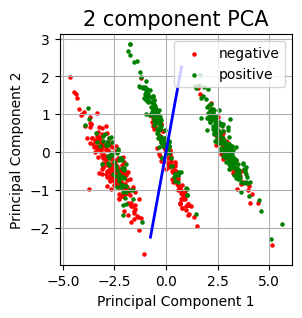

In [ ]:
# Import pcss, project the points onto the first two principal components, plot graph
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_train_ft)
principalDf = pd.DataFrame(data = principalComponents
                , columns = ['principal component 1', 'principal component 2'])
principalDf['label'] = y_train_ft
principalDf['label'] = principalDf['label'].map({0:'negative', 1:'positive'})

# Plot the graph
fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('2 component PCA', fontsize = 15)
targets = ['negative', 'positive']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['label'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 5)
ax.legend(targets)
ax.grid()
lr_projected = pca.transform(lr_ft.coef_)
ax.plot([-lr_projected[0][0], lr_projected[0][0]], [-lr_projected[0][1], lr_projected[0][1]], color='blue', linewidth=2)

In [ ]:
lr_pred_ft_and = lr_ft.predict(x_test_ft[and_indx_rev])
print("Logistic regression accuracy and: {}".format(lr_ft.score(x_test_ft[and_indx_rev], y_test_ft[and_indx_rev])))
print(lr_pred_ft_and.mean())
lr_pred_ft_or = lr_ft.predict(x_test_ft[or_indx_rev])
print("Logistic regression accuracy or: {}".format(lr_ft.score(x_test_ft[or_indx_rev], y_test_ft[or_indx_rev])))
print(lr_pred_ft_or.mean())
lr_pred_ft_plain = lr_ft.predict(x_test_ft[plain_indx_rev])
print("Logistic regression accuracy single: {}".format(lr_ft.score(x_test_ft[plain_indx_rev], y_test_ft[plain_indx_rev])))
print(lr_pred_ft_plain.mean())

Logistic regression accuracy and: 0.9
0.12916666666666668
Logistic regression accuracy or: 0.8735632183908046
0.49808429118773945
Logistic regression accuracy single: 0.8875502008032129
0.5823293172690763


In [ ]:
# Train CCS without any labels
ccs_ft = CCS(false_hs_train, true_hs_train)
loss, all_losses = ccs_ft.repeated_train()

# Evaluate
ccs_pred_ft, ccs_acc_ft = ccs_ft.get_acc(false_hs_test, true_hs_test, y_test_ft, conj=True)
print("CCS test accuracy: {}".format(ccs_acc_ft))

CCS test accuracy: 0.2986666666666667


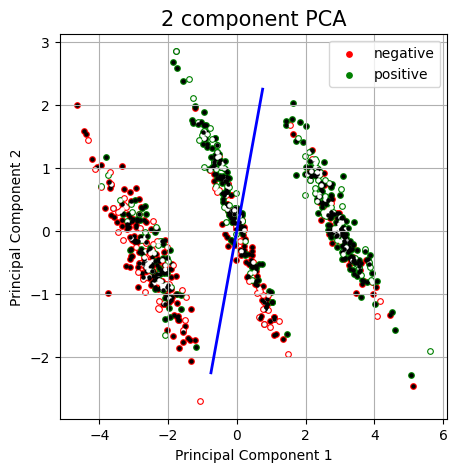

In [ ]:
# Import pcss, project the points onto the first two principal components, plot graph
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_train_ft)
principalDf = pd.DataFrame(data = principalComponents
                , columns = ['principal component 1', 'principal component 2'])
principalDf['label'] = y_train_ft
principalDf['label'] = principalDf['label'].map({0:'negative', 1:'positive'})

# Plot the graph
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('2 component PCA', fontsize = 15)
targets = ['negative', 'positive']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['label'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 15)
ax.legend(targets)
ax.grid()
lr_projected = pca.transform(lr_ft.coef_)
ax.plot([-lr_projected[0][0], lr_projected[0][0]], [-lr_projected[0][1], lr_projected[0][1]], color='blue', linewidth=2)

# Indicate CCS predictions on graph
for i in range(len(ccs_pred_ft)):
    if ccs_pred_ft[i] == 0:
        ax.scatter(principalComponents[i, 0], principalComponents[i, 1], c='k', s=5)
    else:
        ax.scatter(principalComponents[i, 0], principalComponents[i, 1], c='w', s=5)

In [ ]:
# ccs_pred_ft_and = ccs_ft.predict(x_test_ft[and_indx_rev])
for s, indx_class in zip(["and", "or", "plain"], [and_indx_rev, or_indx_rev, plain_indx_rev]):
    ccs_pred_ft, ccs_acc_ft = ccs_ft.get_acc(false_hs_test[indx_class], true_hs_test[indx_class], y_test_ft[indx_class], conj=True)
    print("CCS accuracy {}: {}".format(s, ccs_acc_ft))
    print(ccs_pred_ft.mean())

CCS accuracy and: 0.3958333333333333
0.475
CCS accuracy or: 0.2796934865900383
0.34099616858237547
CCS accuracy plain: 0.37349397590361444
0.5180722891566265


In [ ]:
# Look at the ands and ors. The ors should predict more stuff is right than the ands. Ig this is not the case, flip it.
ccs_pred_ft_and, ccs_acc_ft_and = ccs_ft.get_acc(false_hs_test[and_indx_rev], true_hs_test[and_indx_rev], y_test_ft[and_indx_rev], conj=True)
ccs_pred_ft_or, ccs_acc_ft_or = ccs_ft.get_acc(false_hs_test[or_indx_rev], true_hs_test[or_indx_rev], y_test_ft[or_indx_rev], conj=True)

if ccs_pred_ft_and.mean() > ccs_pred_ft_or.mean(): # then flip all of the predictions!
    ccs_pred_ft, ccs_acc_ft = ccs_ft.get_acc(false_hs_test, true_hs_test, y_test_ft, conj=True)
    ccs_pred_ft = ccs_pred_ft.dtype.type(ccs_pred_ft == 0)
    ccs_acc_ft = 1 - ccs_acc_ft
print("CCS test accuracy: {}".format(ccs_acc_ft))

CCS test accuracy: 0.7013333333333334


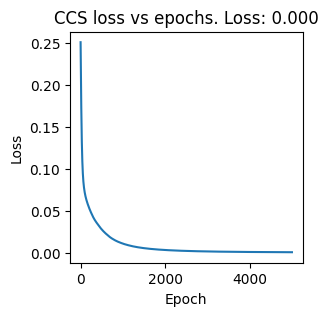

0.00034545117523521185


In [ ]:
plt.figure(figsize=(3,3))
plt.plot(all_losses)
plt.title("CCS loss vs epochs. Loss: {:.3f}".format(loss))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
print(loss)

In [ ]:
# for i in range(250, 300):
#     i1, i2 = rand_indxs[i]
#     i1, i2 = i1.item(), i2.item()
#     print("Item 1:", data[i1]["label"], "Item 2:", data[i2]["label"], " ---- ", "Label:", y_test_ft[i-250], "Prediction:", int(ccs_pred_ft[i-250]==0))
one_one = [i for i, ind in enumerate(rand_indxs[250:]) if data[ind[0].item()]["label"] == 1 and data[ind[1].item()]["label"] == 1]
one_zero = [i for i, ind in enumerate(rand_indxs[250:]) if data[ind[0].item()]["label"] == 1 and data[ind[1].item()]["label"] == 0]
zero_one = [i for i, ind in enumerate(rand_indxs[250:]) if data[ind[0].item()]["label"] == 0 and data[ind[1].item()]["label"] == 1]
zero_zero = [i for i, ind in enumerate(rand_indxs[250:]) if data[ind[0].item()]["label"] == 0 and data[ind[1].item()]["label"] == 0]

for s, oz in zip(["1-1", "1-0", "0-1", "0-0"], [one_one, one_zero, zero_one, zero_zero]):
    ccs_pred_ft_oz, ccs_acc_ft_oz = ccs_ft.get_acc(false_hs_test[oz], true_hs_test[oz], y_test_ft[oz], conj=True)
    print("CCS test accuracy {}: {}".format(s, ccs_acc_ft_oz))

CCS test accuracy 1-1: 0.3
CCS test accuracy 1-0: 0.25
CCS test accuracy 0-1: 0.2833333333333333
CCS test accuracy 0-0: 0.25757575757575757


In [ ]:
ccs_pred_ft_and, ccs_acc_ft_and = ccs_ft.get_acc(false_hs_test[and_indx_rev], true_hs_test[and_indx_rev], y_test_ft[and_indx_rev], conj=True)
ccs_pred_ft_or, ccs_acc_ft_or = ccs_ft.get_acc(false_hs_test[or_indx_rev], true_hs_test[or_indx_rev], y_test_ft[or_indx_rev], conj=True)
print("CCS accuracy and: {}".format(ccs_acc_ft_and))
print("CCS accuracy or: {}".format(ccs_acc_ft_or))
print(y_test_ftv.mean())
print(y_test_ft[or_indx_rev].mean())
print(ccs_pred_ft_and.mean())
print(ccs_pred_ft_or.mean())

IndexError: ignored

In [ ]:
# # A baseline of a random linear probe
random_ccs_ft = CCS(false_hs_train, true_hs_train)
ccs_random_pred_ft, ccs_random_acc_ft = random_ccs_ft.get_acc(false_hs_test, true_hs_test, y_test_ft, conj=True)
print("Random accuracy: {}".format(ccs_random_acc_ft))

Random accuracy: 0.516


In [ ]:
# # Print first 20 predictions for ccs_pred, lr_pred, and y_test. Also, print overlap percent between ccs_pred and lr_pred.
print("Random predictions: \t{}".format(ccs_random_pred_ft[:30]))
print("CCS predictions: \t{}".format(ccs_pred_ft[:30]))
print("LR predictions: \t{}".format(lr_pred_ft[:30]))
print("True labels: \t\t{}".format(y_test_ft[:30]))
print()
print("CCS and logistic regression overlap: {}".format(np.mean(ccs_pred_ft == lr_pred_ft)))
print("CCS and random overlap: {}".format(np.mean(ccs_pred_ft != ccs_random_pred_ft)))
print("Logistic regression and random overlap: {}".format(np.mean(lr_pred_ft != ccs_random_pred_ft)))
print()
print("Random true: {}".format(ccs_random_pred_ft.sum()))
print("CCS true: {}".format(ccs_pred_ft.sum()))
print("LR true: {}".format(lr_pred_ft.sum()))
print("True labels true: {}".format(y_test_ft.sum()))

Random predictions: 	[0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0]
CCS predictions: 	[1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 1]
LR predictions: 	[0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True labels: 		[0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

CCS and logistic regression overlap: 0.456
CCS and random overlap: 0.696
Logistic regression and random overlap: 0.488

Random true: 130
CCS true: 114
LR true: 64
True labels true: 61


In [ ]:
y_test_ft[:10]

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0])

## Let's see how it transfers among datasets
We will train the linear probe on one dataset and test it on others.

In [ ]:
# Train CCS on amazon_polarity dataset
ccs = CCS(neg_hs_train_amazon_polarity, pos_hs_train_amazon_polarity)
ccs.repeated_train()
print("Train CCS on amazon_polarity dataset")
# Test CCS on imdb and amazon_polarity dataset
ccs_acc = ccs.get_acc(neg_hs_test_imdb, pos_hs_test_imdb, y_test_imdb)
print("CCS accuracy on imdb: {}".format(ccs_acc))
ccs_acc = ccs.get_acc(neg_hs_test_amazon_polarity, pos_hs_test_amazon_polarity, y_test_amazon_polarity)
print("CCS accuracy on amazon_polarity: {}".format(ccs_acc))

Train CCS on amazon_polarity dataset
CCS accuracy on imdb: 0.74
CCS accuracy on amazon_polarity: 0.82


In [ ]:
# Train CCS on imdb dataset
seeds = np.arange(10)
accs_imdb_train = []
accs_imdb_test = []
accs_amazon_test = []

for seed in seeds:
  np.random.seed(seed)
  ccs = CCS(neg_hs_train_imdb, pos_hs_train_imdb)
  ccs.repeated_train()
  print("Train CCS on imdb dataset")
  # Test CCS on imdb and amazon_polarity dataset
  ccs_acc = ccs.get_acc(neg_hs_train_imdb, pos_hs_train_imdb, y_train_imdb)
  accs_imdb_train.append(ccs_acc)
  print("CCS accuracy on imdb trainset: {}".format(ccs_acc))
  ccs_acc = ccs.get_acc(neg_hs_test_imdb, pos_hs_test_imdb, y_test_imdb)
  accs_imdb_test.append(ccs_acc)
  print("CCS accuracy on imdb testset: {}".format(ccs_acc))
  ccs_acc = ccs.get_acc(neg_hs_test_amazon_polarity, pos_hs_test_amazon_polarity, y_test_amazon_polarity)
  accs_amazon_test.append(ccs_acc)
  print("CCS accuracy on amazon_polarity: {}".format(ccs_acc))

accs_imdb_train = np.array(accs_imdb_train)
print(f"CCS accuracy on imdb trainset - Mean: {np.mean(accs_imdb_train)}; Std: {np.std(accs_imdb_train)}")
accs_imdb_test = np.array(accs_imdb_test)
print(f"CCS accuracy on imdb testset - Mean: {np.mean(accs_imdb_test)}; Std: {np.std(accs_imdb_test)}")
accs_amazon_test = np.array(accs_amazon_test)
print(f"CCS accuracy on amazon testset - Mean: {np.mean(accs_amazon_test)}; Std: {np.std(accs_amazon_test)}")

Train CCS on imdb dataset
CCS accuracy on imdb trainset: 0.86
CCS accuracy on imdb testset: 0.7
CCS accuracy on amazon_polarity: 0.7
Train CCS on imdb dataset
CCS accuracy on imdb trainset: 0.88
CCS accuracy on imdb testset: 0.76
CCS accuracy on amazon_polarity: 0.72
Train CCS on imdb dataset
CCS accuracy on imdb trainset: 0.88
CCS accuracy on imdb testset: 0.68
CCS accuracy on amazon_polarity: 0.7
Train CCS on imdb dataset
CCS accuracy on imdb trainset: 0.86
CCS accuracy on imdb testset: 0.68
CCS accuracy on amazon_polarity: 0.68
Train CCS on imdb dataset
CCS accuracy on imdb trainset: 0.88
CCS accuracy on imdb testset: 0.68
CCS accuracy on amazon_polarity: 0.7
Train CCS on imdb dataset
CCS accuracy on imdb trainset: 0.86
CCS accuracy on imdb testset: 0.7
CCS accuracy on amazon_polarity: 0.6599999999999999
Train CCS on imdb dataset
CCS accuracy on imdb trainset: 0.88
CCS accuracy on imdb testset: 0.76
CCS accuracy on amazon_polarity: 0.74
Train CCS on imdb dataset
CCS accuracy on imdb

## Let's plot the heatmap of tranfer results between datasets


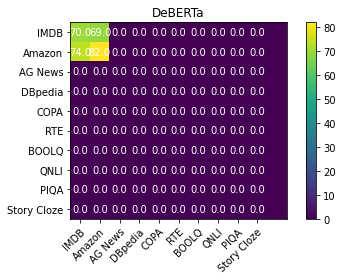

In [ ]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
#               "potato", "wheat", "barley"]
# farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
#            "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]
train_sets = ["IMDB", "Amazon", "AG News", "DBpedia", "COPA", "RTE", "BOOLQ", "QNLI", "PIQA", "Story Cloze"]
test_sets = ["IMDB", "Amazon", "AG News", "DBpedia", "COPA", "RTE", "BOOLQ", "QNLI", "PIQA", "Story Cloze"]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0, 0.0, 0.0, 0,0], # random placeholder stuff
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0, 0.0, 0.0, 0,0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0, 0.0, 0.0, 0,0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0, 0.0, 0.0, 0,0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0, 0.0, 0.0, 0,0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1, 0.0, 0.0, 0,0],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3, 0.0, 0.0, 0,0],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3, 0.0, 0.0, 0,0],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3, 0.0, 0.0, 0,0],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3, 0.0, 0.0, 0,0]
                    ])
harvest = np.zeros_like(harvest)
harvest[0][0] = 70
harvest[0][1] = 69
harvest[1][0] = 74
harvest[1][1] = 82
# harvest += 50

fig, ax = plt.subplots()
im = ax.imshow(harvest)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(test_sets)), labels=test_sets)
ax.set_yticks(np.arange(len(train_sets)), labels=train_sets)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(train_sets)):
    for j in range(len(test_sets)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("DeBERTa")
fig.tight_layout()

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("", rotation=-90, va="bottom")

plt.show()

Please note that in the plot above we use zeros as placeholders for the values we did not calculate.

Our values are decidedly lower from those of the paper. One reason could be that we use fewer training samples (100) than the paper did to generate this plot. We can explore this further later.

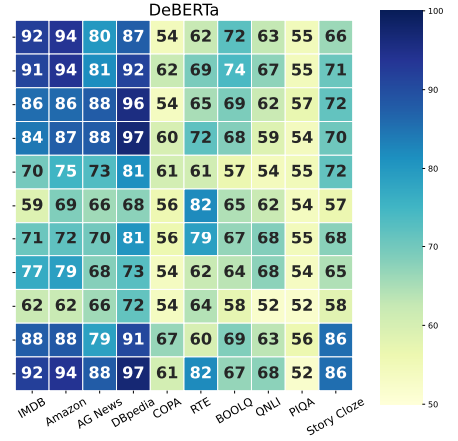

## We found that the performance can depend upon how the prompt is phrased. We illustrate this variance in the following plot:

Plot the mean and std of 10 trials for each of three different prompt types (box chart thingy).

For now we focus only on the IMDB dataset

For context: Here are the prompts next to their number codes:

1. f"Consider the following example: “‘ {text} ”’ Between {labels[0]} and {labels[1]}, the sentiment of this example is {labels[label]}\n"

2. f"Q: Is the sentiment of \"{text}\" {labels[0]} or {labels[1]}? A: {labels[label]}\n"

3. "The following movie review expresses a " + ["negative", "positive"][label] + " sentiment:\n" + text

In [ ]:
# format style 1
neg_imdb1, pos_imdb1, y_imdb1 = get_hidden_states_many_examples(model, tokenizer, data_imdb, model_type, "imdb", 100, 1)
neg_hs_train_imdb1, neg_hs_test_imdb1, pos_hs_train_imdb1, pos_hs_test_imdb1, y_train_imdb1, y_test_imdb1 = train_test_split(neg_imdb1, pos_imdb1, y_imdb1)

# format style 2
neg_imdb2, pos_imdb2, y_imdb2 = get_hidden_states_many_examples(model, tokenizer, data_imdb, model_type, "imdb", 100, 2)
neg_hs_train_imdb2, neg_hs_test_imdb2, pos_hs_train_imdb2, pos_hs_test_imdb2, y_train_imdb2, y_test_imdb2 = train_test_split(neg_imdb2, pos_imdb2, y_imdb2)

# format style 3
neg_imdb3, pos_imdb3, y_imdb3 = get_hidden_states_many_examples(model, tokenizer, data_imdb, model_type, "imdb", 100, 3)
neg_hs_train_imdb3, neg_hs_test_imdb3, pos_hs_train_imdb3, pos_hs_test_imdb3, y_train_imdb3, y_test_imdb3 = train_test_split(neg_imdb3, pos_imdb3, y_imdb3)

100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


In [ ]:
def run_trials(neg_hs_train, pos_hs_train, neg_hs_test, pos_hs_test, y_train, y_test, ntrials=10):
  seeds = np.arange(ntrials)
  accs_train = []
  accs_test = []
  rand_train = []
  rand_test = []

  for seed in seeds:
    np.random.seed(seed) # CHLOE NOTE: I don't think this seed is doing what we want (but idk how to really tell)
    ccs = CCS(neg_hs_train, pos_hs_train)
    rand_ccs = CCS(neg_hs_train, pos_hs_train)
    ccs.repeated_train()
    print("Train CCS on dataset")
    # Test CCS on imdb and amazon_polarity dataset
    ccs_acc = ccs.get_acc(neg_hs_train, pos_hs_train, y_train)
    accs_train.append(ccs_acc)
    print("CCS accuracy on trainset: {}".format(ccs_acc))
    ccs_acc = ccs.get_acc(neg_hs_test, pos_hs_test, y_test)
    accs_test.append(ccs_acc)
    print("CCS accuracy on testset: {}".format(ccs_acc))
    rccs_acc = rand_ccs.get_acc(neg_hs_train, pos_hs_train, y_train)
    rand_train.append(rccs_acc)
    print("Random CCS accuracy on trainset: {}".format(ccs_acc))
    rccs_acc = rand_ccs.get_acc(neg_hs_test, pos_hs_test, y_test)
    rand_test.append(rccs_acc)
    print("Random CCS accuracy on testset: {}".format(ccs_acc))

  accs_train = np.array(accs_train)
  print(f"CCS accuracy on trainset - Mean: {np.mean(accs_train)}; Std: {np.std(accs_train)}")
  accs_test = np.array(accs_test)
  print(f"CCS accuracy on testset - Mean: {np.mean(accs_test)}; Std: {np.std(accs_test)}")
  rand_train = np.array(rand_train)
  print(f"Rand accuracy on trainset - Mean: {np.mean(rand_train)}; Std: {np.std(rand_train)}")
  rand_test = np.array(rand_test)
  print(f"Rand accuracy on testset - Mean: {np.mean(rand_test)}; Std: {np.std(rand_test)}")

  return accs_train, accs_test, rand_train, rand_test

In [ ]:
ccs_train1, ccs_test1, rand_train1, rand_test1 = run_trials(neg_hs_train_imdb1, pos_hs_train_imdb1, neg_hs_test_imdb1, pos_hs_test_imdb1, y_train_imdb1, y_test_imdb1)

Train CCS on dataset
CCS accuracy on trainset: 0.8200000000000001
CCS accuracy on testset: 0.96
Random CCS accuracy on trainset: 0.96
Random CCS accuracy on testset: 0.96
Train CCS on dataset
CCS accuracy on trainset: 0.84
CCS accuracy on testset: 0.96
Random CCS accuracy on trainset: 0.96
Random CCS accuracy on testset: 0.96
Train CCS on dataset
CCS accuracy on trainset: 0.82
CCS accuracy on testset: 0.96
Random CCS accuracy on trainset: 0.96
Random CCS accuracy on testset: 0.96
Train CCS on dataset
CCS accuracy on trainset: 0.8200000000000001
CCS accuracy on testset: 0.96
Random CCS accuracy on trainset: 0.96
Random CCS accuracy on testset: 0.96
Train CCS on dataset
CCS accuracy on trainset: 0.82
CCS accuracy on testset: 0.96
Random CCS accuracy on trainset: 0.96
Random CCS accuracy on testset: 0.96
Train CCS on dataset
CCS accuracy on trainset: 0.82
CCS accuracy on testset: 0.96
Random CCS accuracy on trainset: 0.96
Random CCS accuracy on testset: 0.96
Train CCS on dataset
CCS accur

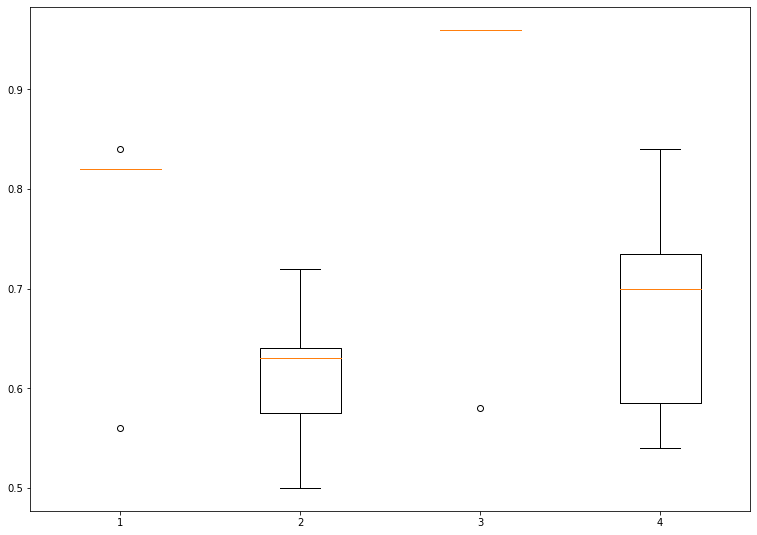

In [ ]:
import matplotlib.pyplot as plt

# create whisker plot
data = [ccs_train1, rand_train1, ccs_test1, rand_test1]

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

In [ ]:
ccs_train2, ccs_test2, rand_train2, rand_test2 = run_trials(neg_hs_train_imdb2, pos_hs_train_imdb2, neg_hs_test_imdb2, pos_hs_test_imdb2, y_train_imdb2, y_test_imdb2)

Train CCS on dataset
CCS accuracy on trainset: 0.56
CCS accuracy on testset: 0.52
Random CCS accuracy on trainset: 0.52
Random CCS accuracy on testset: 0.52
Train CCS on dataset
CCS accuracy on trainset: 0.56
CCS accuracy on testset: 0.52
Random CCS accuracy on trainset: 0.52
Random CCS accuracy on testset: 0.52
Train CCS on dataset
CCS accuracy on trainset: 0.56
CCS accuracy on testset: 0.52
Random CCS accuracy on trainset: 0.52
Random CCS accuracy on testset: 0.52
Train CCS on dataset
CCS accuracy on trainset: 0.56
CCS accuracy on testset: 0.52
Random CCS accuracy on trainset: 0.52
Random CCS accuracy on testset: 0.52
Train CCS on dataset
CCS accuracy on trainset: 0.56
CCS accuracy on testset: 0.52
Random CCS accuracy on trainset: 0.52
Random CCS accuracy on testset: 0.52
Train CCS on dataset
CCS accuracy on trainset: 0.56
CCS accuracy on testset: 0.52
Random CCS accuracy on trainset: 0.52
Random CCS accuracy on testset: 0.52
Train CCS on dataset
CCS accuracy on trainset: 0.56
CCS ac

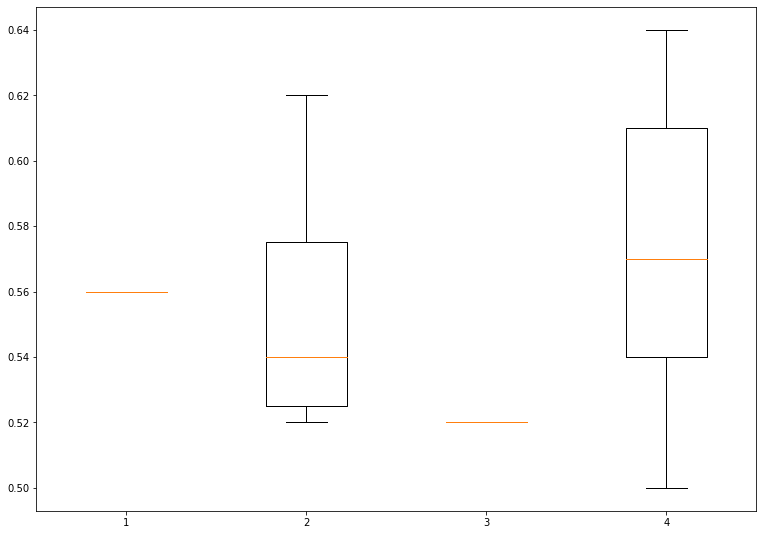

In [ ]:
import matplotlib.pyplot as plt

# create whisker plot
data = [ccs_train2, rand_train2, ccs_test2, rand_test2]

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

In [ ]:
ccs_train3, ccs_test3, rand_train3, rand_test3 = run_trials(neg_hs_train_imdb3, pos_hs_train_imdb3, neg_hs_test_imdb3, pos_hs_test_imdb3, y_train_imdb3, y_test_imdb3)

Train CCS on dataset
CCS accuracy on trainset: 0.92
CCS accuracy on testset: 0.94
Random CCS accuracy on trainset: 0.94
Random CCS accuracy on testset: 0.94
Train CCS on dataset
CCS accuracy on trainset: 0.9
CCS accuracy on testset: 0.92
Random CCS accuracy on trainset: 0.92
Random CCS accuracy on testset: 0.92
Train CCS on dataset
CCS accuracy on trainset: 0.84
CCS accuracy on testset: 0.94
Random CCS accuracy on trainset: 0.94
Random CCS accuracy on testset: 0.94
Train CCS on dataset
CCS accuracy on trainset: 0.92
CCS accuracy on testset: 0.94
Random CCS accuracy on trainset: 0.94
Random CCS accuracy on testset: 0.94
Train CCS on dataset
CCS accuracy on trainset: 0.92
CCS accuracy on testset: 0.94
Random CCS accuracy on trainset: 0.94
Random CCS accuracy on testset: 0.94
Train CCS on dataset
CCS accuracy on trainset: 0.92
CCS accuracy on testset: 0.94
Random CCS accuracy on trainset: 0.94
Random CCS accuracy on testset: 0.94
Train CCS on dataset
CCS accuracy on trainset: 0.88
CCS acc

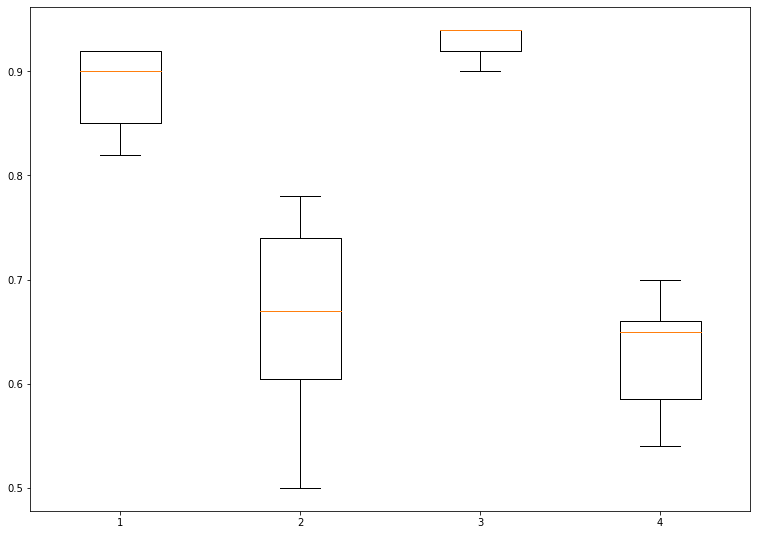

In [ ]:
import matplotlib.pyplot as plt

# create whisker plot
data = [ccs_train3, rand_train3, ccs_test3, rand_test3]

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

<ipython-input-52-20755614aa93>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['ccs train prompt 1', 'random train prompt 1',


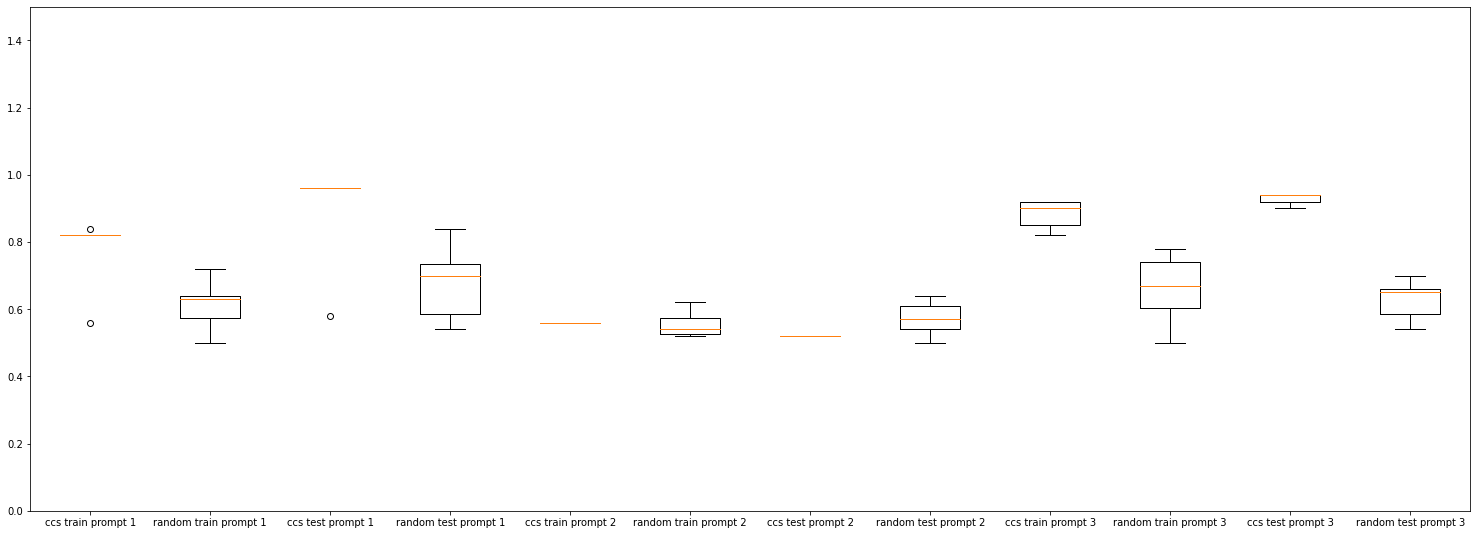

In [ ]:
import matplotlib.pyplot as plt

# create whisker plot
data = [ccs_train1, rand_train1, ccs_test1, rand_test1, ccs_train2, rand_train2, ccs_test2, rand_test2, ccs_train3, rand_train3, ccs_test3, rand_test3]

fig = plt.figure(figsize =(20, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylim(0,1.5)

# set x-axis labels
ax.set_xticklabels(['ccs train prompt 1', 'random train prompt 1',
                    'ccs test prompt 1', 'random test prompt 1', 'ccs train prompt 2', 'random train prompt 2',
                    'ccs test prompt 2', 'random test prompt 2', 'ccs train prompt 3', 'random train prompt 3',
                    'ccs test prompt 3', 'random test prompt 3'])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

From left to right in the plot above:

ccs accuracy on train with prompt 1, random baseline on train prompt 1, ccs accuracy on test with prompt 1, random baseline on test prompt 1,
ccs accuracy on train with prompt 2, random baseline on train prompt 2, ccs accuracy on test with prompt 2, random baseline on test prompt 2,
ccs accuracy on train with prompt 3, random baseline on train prompt 3, ccs accuracy on test with prompt 3, random baseline on test prompt 3

For some reason, the second prompt format destroys the performance of the model. Why???


# Immediate Next Steps



*   visualize the clusters of model hidden states corresponding to true and false inputs. (we will need to lower the dimension of the hidden state vectors.)
*   observe how these clusters differ for different prompt formulations

*   We are doing this because we are curious about whether the data is easy or hard to separate. this will give us intuition for whether a random cluster should do well or poorly on the dataset. also, it would be helpful to understand whether each dataset gives rise to two clean clusters or whether they overlap to some extent.



